In [162]:
import random
import numpy as np
from abc import ABC, abstractmethod

### Generic Genetic Optimizer

In [451]:
class GeneticOptimizer(ABC):
    def __init__(self, stats_collector=None):
        self.temp = 1.0
        self.stats_collector = stats_collector
    
    @abstractmethod
    def update_temp(self, gen, fitness):
        pass

    @abstractmethod
    def calc_sel_percent(self):
        pass

    @abstractmethod
    def calc_mutation_rate(self):
        pass

    @abstractmethod
    def calc_fitness(self, population):
        pass
    
    @abstractmethod
    def breed(self, couple):
        pass

    @abstractmethod
    def mutate(self, individual):
        pass

    def record_fitness(self, gen, fitness):
        if self.stats_collector:
            self.stats_collector.add_fitness(gen, fitness)
    
    def select(self, population, fitness, n_parents):
        return population[np.argsort(fitness)][-n_parents:]

    def crossover(self, parents, n_offsprings):
        offsprings = np.empty((n_offsprings, *parents.shape[1:]), dtype=parents.dtype)
        for i in range(n_offsprings):
            couple = parents[np.random.choice(parents.shape[0], size=(2,), replace=False)]
            offsprings[i] = self.breed(couple)
        return offsprings

    def next_generation(self, population, pop_fitness):
        n_parents = max(2, int(population.shape[0] * self.calc_sel_percent()))
        n_offsprings = population.shape[0] - n_parents
        
        adv_pop = np.empty(population.shape)
        adv_pop[:n_parents] = self.select(population, pop_fitness, n_parents)
        offsprings = self.crossover(adv_pop[:n_parents], n_offsprings)
        for i in range(n_offsprings):
            adv_pop[n_parents + i] = self.mutate(offsprings[i]) if random.random() < self.calc_mutation_rate() else offsprings[i]

        return adv_pop

    
    def optimize(self, population, n_generations, temperature=1.0, fitness_threshold=1.0):
        assert(population.shape[0] >= 3)
        self.temp = temperature


        for gen in range(n_generations):
            fitness = self.calc_fitness(population)
            self.record_fitness(gen, fitness)
            if(np.any(fitness >= fitness_threshold)):
                break
            population = self.next_generation(population, fitness)
            self.update_temp(gen, fitness)


### Knapsack Genetic Optimizer

In [493]:
class KnapsackOptimizer(GeneticOptimizer):
    def __init__(self, weights, values, max_weight, stats_collector=None):
        super(KnapsackOptimizer, self).__init__(stats_collector=stats_collector)
        weight = lambda i: np.sum(weights[np.nonzero(i)])
        value = lambda i: np.sum(values[np.nonzero(i)])
        self.fitness = np.vectorize(
            lambda i: value(i) if weight(i) <= max_weight else 0, signature="(n)->()")
    
    def update_temp(self, gen, fitness):
        return 1.0 - (gen / 100)

    def calc_sel_percent(self):
        return 1 - self.temp

    def calc_mutation_rate(self):
        return self.temp

    def calc_fitness(self, population):
        return self.fitness(population)
    
    def breed(self, couple):
        crossover_point = int(couple.shape[1]/2)
        offspring = np.copy(couple[0])
        offspring[crossover_point:] = couple[1][crossover_point:]
        return offspring

    def mutate(self, individual):
        mutant = np.copy(individual)
        i = random.randint(0, individual.shape[0]-1)
        mutant[i] = (mutant[i] + 1) % 2
        return mutant

In [494]:
import matplotlib.pyplot as plt

class KnapsackStatsCollector:
    def __init__(self):
        self.fitness_log = []
    
    def add_fitness(self, gen, fitness):
        self.fitness_log.append(fitness)
    
    def max_fit(self):
        max_fit = []
        for f in self.fitness_log:
            max_fit.append(max(f))
        return max_fit
    
    def avg_fit(self):
        avg_fit = []
        for f in self.fitness_log:
            avg_fit.append(sum(f) / len(f))
        return avg_fit
    
    def plot(self):
        n_gens = len(self.fitness_log)
        plt.plot(list(range(n_gens)), self.avg_fit(), label = 'Mean Fitness')
        plt.plot(list(range(n_gens)), self.max_fit(), label = 'Max Fitness')
        plt.legend()
        plt.title('Fitness through the generations')
        plt.xlabel('Generations')
        plt.ylabel('Fitness')
        plt.show()

In [495]:
def as_bin_list(x, n_bits):
    bin_list = []
    for i in range(n_bits):
        bin_list.append((x >> i) & 0x01)
    bin_list.reverse()
    return bin_list

def brute_optimal_knapsack(weights, values, max_weight):
    weight = lambda i: np.sum(weights[np.nonzero(i)])
    value = lambda i: np.sum(values[np.nonzero(i)])
    fit = lambda i: value(i) if weight(i) <= max_weight else 0
    n_bits = len(weights)
    best = 0
    for i in range(pow(2, n_bits)):
        best = i if fit(as_bin_list(i, n_bits)) > fit(as_bin_list(best, n_bits)) else best
    
    return best, value(as_bin_list(best, n_bits))


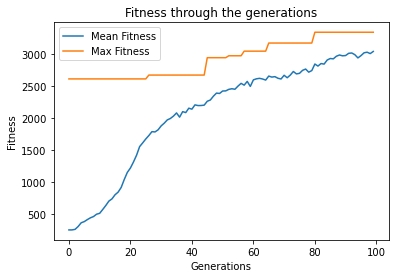

fnd: 3345
max: 3748
dlt: 403
acc: 0.8924759871931697


In [502]:
knapsack_size = 16
pop_size = 100
weights = np.random.randint(1, 15, size = knapsack_size)
values = np.random.randint(10, 750, size = knapsack_size)
max_weight = 35    #Maximum weight that the bag of thief can hold 

stats_collector = KnapsackStatsCollector()
opt = KnapsackOptimizer(weights=weights, values=values, max_weight=max_weight, stats_collector=stats_collector)

population = np.random.randint(2, size=(pop_size, knapsack_size))

opt.optimize(population, n_generations=100, fitness_threshold=sum(values), temperature=0.1 )

stats_collector.plot()

fnd_value = max(stats_collector.max_fit())
print(f'fnd: {fnd_value}')
max_value = brute_optimal_knapsack(weights, values, max_weight)[1]
print(f'max: {max_value}')
print(f'dlt: {max_value - fnd_value}')
print(f'acc: {fnd_value / max_value}')

### 